## 1. DataSet import

In [26]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *

X, y , feature_names , categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [27]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Model

In [28]:
# Taken from https://github.com/dylan-slack/manipulating-cfes/blob/main/train_models.py
# wanted to use this the same model as in the paper
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, return_logit=False):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.tanh3(out)
        out = self.fc4(out)
        return out


In [29]:
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [31]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 2000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model.to(device)

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train.cpu().detach().numpy(),
        y_pred=y_pred.cpu().detach().numpy()
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test.cpu().detach().numpy(),
            y_pred=test_pred.cpu().detach().numpy()
        )

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%")

Epoch: 0 | Loss: 0.67509, F1-Training: 0.82% | Test loss: 0.64846, F1-Testing: 0.83%
Epoch: 100 | Loss: 0.57938, F1-Training: 0.82% | Test loss: 0.58522, F1-Testing: 0.83%
Epoch: 200 | Loss: 0.55606, F1-Training: 0.82% | Test loss: 0.57284, F1-Testing: 0.83%
Epoch: 300 | Loss: 0.54250, F1-Training: 0.82% | Test loss: 0.57369, F1-Testing: 0.84%
Epoch: 400 | Loss: 0.52682, F1-Training: 0.82% | Test loss: 0.57776, F1-Testing: 0.83%
Epoch: 500 | Loss: 0.51499, F1-Training: 0.83% | Test loss: 0.57794, F1-Testing: 0.84%
Epoch: 600 | Loss: 0.49932, F1-Training: 0.83% | Test loss: 0.56785, F1-Testing: 0.83%
Epoch: 700 | Loss: 0.48692, F1-Training: 0.84% | Test loss: 0.56500, F1-Testing: 0.83%
Epoch: 800 | Loss: 0.47693, F1-Training: 0.84% | Test loss: 0.56451, F1-Testing: 0.82%
Epoch: 900 | Loss: 0.46768, F1-Training: 0.84% | Test loss: 0.56628, F1-Testing: 0.83%
Epoch: 1000 | Loss: 0.46220, F1-Training: 0.85% | Test loss: 0.57542, F1-Testing: 0.83%
Epoch: 1100 | Loss: 0.45286, F1-Training: 0.

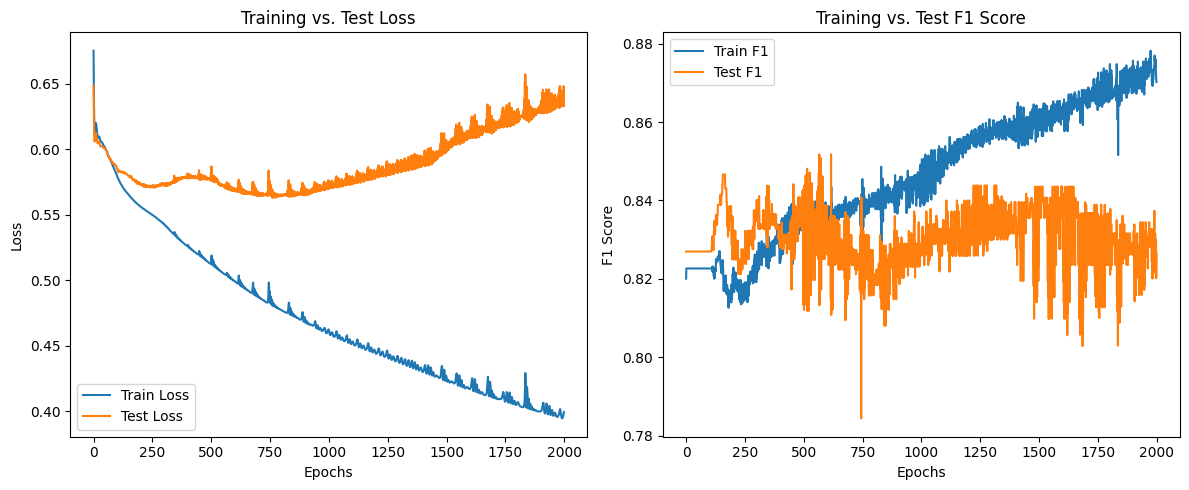

In [32]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Counterfactual generation:
### 4.1. of one Instance

In [33]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

In [34]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)  # Use softmax instead of sigmoid
            return probabilities.cpu().numpy()

dice_model = dice_ml.Model(
    model=PyTorchModelWrapper(model),
    backend="sklearn",
    model_type='classifier'
)

exp = dice_ml.Dice(
    dice_data,
    dice_model,
    method="genetic"
)


In [35]:

query_instance = X[11:12]
query_df = pd.DataFrame(query_instance, columns=feature_names)


#  generate counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary = actionable_features
)

print("\nCounterfactuals:")
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Counterfactuals:
Query instance (original outcome : 0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,1.0,0.0,0.0,24.0,48.0,4308.0,3.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,-,-,-,-,4.0,-,-,-,-,-,...,-,-,-,1.0,-,-,0.0,-,-,1.0


### 4.2. calculating L1 Distance

In [36]:
# get counterfactuals as list
cf_list = dice_exp.cf_examples_list[0].final_cfs_df.values.tolist()

# Convert query_instance to tensor
if isinstance(query_instance, np.ndarray):
    query_instance = torch.from_numpy(query_instance).float()

for cf in cf_list:
    # Convert cf to tensor
    if isinstance(cf, list):
        cf = np.array(cf)
    if isinstance(cf, np.ndarray):
        cf = torch.from_numpy(cf).float()

    cf_features = cf[:-1]  # all features except the last one which is the target
    query_features = query_instance.squeeze()

    with torch.no_grad():
        # Calculate L1 distance between feature vectors
        distance = torch.norm(query_features - cf_features, p=1)
        print(f"L1 distance between query and counterfactual: {distance.item()}")

L1 distance between query and counterfactual: 119.0


## 4.3. Calculating the mean value of all L1 Distances of negatively classified instances

In [37]:
from Helper_functions import *

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(model, X)


In [38]:
query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary=actionable_features
)

100%|██████████| 205/205 [02:30<00:00,  1.37it/s]


In [39]:
l1_distances = []
for i in range(len(X_negative)):
    original = X_negative[i]
    cf_df = dice_exp.cf_examples_list[i].final_cfs_df#
    if cf_df is None or cf_df.empty:
        continue
    cf_values = cf_df[feature_names].values
    cf_tensor = torch.from_numpy(cf_values).float().to(device)
    distance = torch.norm(original - cf_tensor, p=1).item()
    l1_distances.append(distance)

# Compute mean L1 distance
mean_l1 = np.mean(l1_distances)
print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")

Mean L1 distance for negatively classified data using DiCE: 1372.71


## 5. Saving the model

In [40]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Calculating the initial approximation of recourse

In [ ]:
loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(loaded_model, X)

y_logits_negative = loaded_model(X_negative)
abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
recourse_Approximation = torch.mean(abs_differences)


print(f"initial Recourse Approximation: {recourse_Approximation:.2f}")

## 5. Approximating the Cost of Recourse:


## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [41]:
from sklearn.metrics import accuracy_score

lamda = 0.1
epochs = 1000

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
print(f"Initial Accuracy: {initial_accuracy:.2f}")

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)
accuracies = []
for epoch in range(epochs):
    loaded_model.train()

    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)

    abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)
    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)

        abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        accuracy = accuracy_score(y_test, torch.argmax(loaded_model(X_test), dim=1))

    if epoch % 10 == 0:
        X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

        X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}| Accuracy: {accuracy:.5f}")

Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.28404| Test loss: 1.35548| Accuracy: 0.41333
Epoch: 100 | Loss: 0.24674| Test loss: 0.45346| Accuracy: 0.73333
Epoch: 200 | Loss: 0.23420| Test loss: 0.48138| Accuracy: 0.74000
Epoch: 300 | Loss: 0.20611| Test loss: 0.51342| Accuracy: 0.73667
Epoch: 400 | Loss: 0.18842| Test loss: 0.55920| Accuracy: 0.73667
Epoch: 500 | Loss: 0.16313| Test loss: 0.56570| Accuracy: 0.73000
Epoch: 600 | Loss: 0.13710| Test loss: 0.60566| Accuracy: 0.71667
Epoch: 700 | Loss: 0.14064| Test loss: 0.52854| Accuracy: 0.73000
Epoch: 800 | Loss: 0.07995| Test loss: 0.68391| Accuracy: 0.69333
Epoch: 900 | Loss: 0.17470| Test loss: 1.07387| Accuracy: 0.59667


## Testing for different Lamdas


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

lambdas = np.linspace(0.01, 0.4, 40)
epochs = 1000
mean_accuracies = []
mean_recourse_approximations = []
mean_recourses = []

for lamda in lambdas:
    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

    initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
    print(f"Initial Accuracy: {initial_accuracy:.2f}")

    X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

    X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)

    epoch_accuracies = []
    epoch_recourse = []

    for epoch in range(epochs):
        loaded_model.train()

        y_logits = loaded_model(X_train)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)

            test_loss = test_loss_1 - lamda * test_loss_2

            accuracy = accuracy_score(y_test, torch.argmax(test_logits, dim=1))
            epoch_accuracies.append(accuracy)
            if not torch.isnan(test_loss_2):
                epoch_recourse.append(test_loss_2.item())

        if epoch % 10 == 0:

            X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)
            X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f} | Accuracy: {accuracy:.5f} | Recourse loss: {test_loss_2:.5f}")

    mean_accuracy = np.mean(epoch_accuracies)
    mean_recourse = np.mean(epoch_recourse)

    mean_accuracies.append(mean_accuracy)
    mean_recourse_approximations.append(mean_recourse)

    # calculating the Recourse for all
    X_positive, X_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X)

    query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=1,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    l1_distances = []
    for i in range(len(X_negative)):
        original = X_negative[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df
        if cf_df is None or cf_df.empty:
            continue
        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float().to(device)
        distance = torch.norm(original - cf_tensor, p=1).item()
        l1_distances.append(distance)

    # Compute mean L1 distance
    mean_l1 = np.mean(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")
    mean_recourses.append(mean_l1)

    print(f"Lambda = {lamda:.3f} | Mean Accuracy: {mean_accuracy:.4f} | Mean Recourse Approximations: {mean_recourse:.4f}")






Training for lambda = 0.010
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.38319 | Test loss: 1.85601 | Accuracy: 0.41333 | Recourse loss: 5.54239
Epoch: 100 | Loss: 0.37456 | Test loss: 0.56075 | Accuracy: 0.76000 | Recourse loss: 1.27540
Epoch: 200 | Loss: 0.37059 | Test loss: 0.57269 | Accuracy: 0.75667 | Recourse loss: 1.35605
Epoch: 300 | Loss: 0.36640 | Test loss: 0.58485 | Accuracy: 0.76333 | Recourse loss: 1.38167
Epoch: 400 | Loss: 0.36212 | Test loss: 0.59605 | Accuracy: 0.76000 | Recourse loss: 1.44668
Epoch: 500 | Loss: 0.35743 | Test loss: 0.60702 | Accuracy: 0.75333 | Recourse loss: 1.49263
Epoch: 600 | Loss: 0.35228 | Test loss: 0.61753 | Accuracy: 0.75667 | Recourse loss: 1.59449
Epoch: 700 | Loss: 0.34730 | Test loss: 0.62933 | Accuracy: 0.75333 | Recourse loss: 1.67409
Epoch: 800 | Loss: 0.34252 | Test loss: 0.63842 | Accuracy: 0.75000 | Recourse loss: 1.75199
Epoch: 900 | Loss: 0.33754 | Test loss: 0.64651 | Accuracy: 0.75000 | Recourse loss: 1.76995


100%|██████████| 293/293 [02:57<00:00,  1.65it/s]


Mean L1 distance for negatively classified data using DiCE: 924.90
Lambda = 0.010 | Mean Accuracy: 0.7538 | Mean Recourse Approximations: 1.5547

Training for lambda = 0.020
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.37218 | Test loss: 1.79889 | Accuracy: 0.41333 | Recourse loss: 5.54286
Epoch: 100 | Loss: 0.36390 | Test loss: 0.54992 | Accuracy: 0.75667 | Recourse loss: 1.30630
Epoch: 200 | Loss: 0.35812 | Test loss: 0.56526 | Accuracy: 0.75667 | Recourse loss: 1.38530
Epoch: 300 | Loss: 0.35261 | Test loss: 0.57984 | Accuracy: 0.75000 | Recourse loss: 1.47076
Epoch: 400 | Loss: 0.34685 | Test loss: 0.59271 | Accuracy: 0.75000 | Recourse loss: 1.57557
Epoch: 500 | Loss: 0.34086 | Test loss: 0.60643 | Accuracy: 0.75000 | Recourse loss: 1.65060
Epoch: 600 | Loss: 0.33505 | Test loss: 0.62007 | Accuracy: 0.75667 | Recourse loss: 1.76568
Epoch: 700 | Loss: 0.33025 | Test loss: 0.63142 | Accuracy: 0.75333 | Recourse loss: 1.74596
Epoch: 800 | Loss: 0.32355 | Test loss: 0.64185 | Accuracy: 0

100%|██████████| 298/298 [03:15<00:00,  1.53it/s]


Mean L1 distance for negatively classified data using DiCE: 976.81
Lambda = 0.020 | Mean Accuracy: 0.7507 | Mean Recourse Approximations: 1.7125

Training for lambda = 0.030
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.36116 | Test loss: 1.74355 | Accuracy: 0.41333 | Recourse loss: 5.54354
Epoch: 100 | Loss: 0.35195 | Test loss: 0.53981 | Accuracy: 0.76000 | Recourse loss: 1.36330
Epoch: 200 | Loss: 0.34435 | Test loss: 0.55576 | Accuracy: 0.75000 | Recourse loss: 1.51745
Epoch: 300 | Loss: 0.33736 | Test loss: 0.57315 | Accuracy: 0.74667 | Recourse loss: 1.63320
Epoch: 400 | Loss: 0.33008 | Test loss: 0.59106 | Accuracy: 0.74667 | Recourse loss: 1.72330
Epoch: 500 | Loss: 0.32301 | Test loss: 0.60723 | Accuracy: 0.74667 | Recourse loss: 1.86164
Epoch: 600 | Loss: 0.31056 | Test loss: 0.61664 | Accuracy: 0.74667 | Recourse loss: 2.22705
Epoch: 700 | Loss: 0.31837 | Test loss: 0.62650 | Accuracy: 0.75333 | Recourse loss: 1.72474
Epoch: 800 | Loss: 0.30823 | Test loss: 0.64531 | Accuracy: 0

100%|██████████| 303/303 [04:01<00:00,  1.26it/s]


Mean L1 distance for negatively classified data using DiCE: 851.86
Lambda = 0.030 | Mean Accuracy: 0.7452 | Mean Recourse Approximations: 1.8951

Training for lambda = 0.040
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.35014 | Test loss: 1.68814 | Accuracy: 0.41333 | Recourse loss: 5.54387
Epoch: 100 | Loss: 0.33957 | Test loss: 0.52845 | Accuracy: 0.75000 | Recourse loss: 1.47010
Epoch: 200 | Loss: 0.33013 | Test loss: 0.54858 | Accuracy: 0.73667 | Recourse loss: 1.58646
Epoch: 300 | Loss: 0.32169 | Test loss: 0.56739 | Accuracy: 0.74667 | Recourse loss: 1.74824
Epoch: 400 | Loss: 0.31200 | Test loss: 0.58516 | Accuracy: 0.74667 | Recourse loss: 1.92819
Epoch: 500 | Loss: 0.30291 | Test loss: 0.59989 | Accuracy: 0.75000 | Recourse loss: 2.07094
Epoch: 600 | Loss: 0.29666 | Test loss: 0.61638 | Accuracy: 0.75000 | Recourse loss: 2.04382
Epoch: 700 | Loss: 0.31170 | Test loss: 0.61765 | Accuracy: 0.75667 | Recourse loss: 1.61834
Epoch: 800 | Loss: 0.28098 | Test loss: 0.63946 | Accuracy: 0

100%|██████████| 334/334 [04:44<00:00,  1.18it/s]


Mean L1 distance for negatively classified data using DiCE: 870.06
Lambda = 0.040 | Mean Accuracy: 0.7408 | Mean Recourse Approximations: 2.0735

Training for lambda = 0.050
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.33913 | Test loss: 1.63267 | Accuracy: 0.41333 | Recourse loss: 5.54443
Epoch: 100 | Loss: 0.32672 | Test loss: 0.51941 | Accuracy: 0.74000 | Recourse loss: 1.48484
Epoch: 200 | Loss: 0.31589 | Test loss: 0.53969 | Accuracy: 0.73667 | Recourse loss: 1.69433
Epoch: 300 | Loss: 0.30568 | Test loss: 0.56150 | Accuracy: 0.74333 | Recourse loss: 1.85279
Epoch: 400 | Loss: 0.29561 | Test loss: 0.57937 | Accuracy: 0.74667 | Recourse loss: 2.09324
Epoch: 500 | Loss: 0.27954 | Test loss: 0.59363 | Accuracy: 0.74000 | Recourse loss: 2.33439
Epoch: 600 | Loss: 0.24586 | Test loss: 0.58087 | Accuracy: 0.75000 | Recourse loss: 2.69581
Epoch: 700 | Loss: 0.27139 | Test loss: 0.66152 | Accuracy: 0.70000 | Recourse loss: 3.29766
Epoch: 800 | Loss: 0.26175 | Test loss: 0.66716 | Accuracy: 0

100%|██████████| 345/345 [04:43<00:00,  1.22it/s]


Mean L1 distance for negatively classified data using DiCE: 837.79
Lambda = 0.050 | Mean Accuracy: 0.7356 | Mean Recourse Approximations: 2.3135

Training for lambda = 0.060
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.32811 | Test loss: 1.57726 | Accuracy: 0.41333 | Recourse loss: 5.54479
Epoch: 100 | Loss: 0.31198 | Test loss: 0.50951 | Accuracy: 0.73667 | Recourse loss: 1.52890
Epoch: 200 | Loss: 0.29977 | Test loss: 0.53033 | Accuracy: 0.73667 | Recourse loss: 1.77562
Epoch: 300 | Loss: 0.28614 | Test loss: 0.55314 | Accuracy: 0.74000 | Recourse loss: 2.00768
Epoch: 400 | Loss: 0.27457 | Test loss: 0.57715 | Accuracy: 0.73333 | Recourse loss: 2.23201
Epoch: 500 | Loss: 0.39761 | Test loss: 0.64586 | Accuracy: 0.69667 | Recourse loss: 2.41841
Epoch: 600 | Loss: 0.25146 | Test loss: 0.60567 | Accuracy: 0.72667 | Recourse loss: 2.66488
Epoch: 700 | Loss: 0.23901 | Test loss: 0.63404 | Accuracy: 0.72667 | Recourse loss: 2.88871
Epoch: 800 | Loss: 0.63948 | Test loss: 0.71355 | Accuracy: 0

100%|██████████| 355/355 [04:09<00:00,  1.42it/s]


Mean L1 distance for negatively classified data using DiCE: 781.90
Lambda = 0.060 | Mean Accuracy: 0.7315 | Mean Recourse Approximations: 2.4573

Training for lambda = 0.070
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.31709 | Test loss: 1.52182 | Accuracy: 0.41333 | Recourse loss: 5.54486
Epoch: 100 | Loss: 0.29592 | Test loss: 0.49494 | Accuracy: 0.74000 | Recourse loss: 1.65959
Epoch: 200 | Loss: 0.28284 | Test loss: 0.51796 | Accuracy: 0.74667 | Recourse loss: 1.90830
Epoch: 300 | Loss: 0.26578 | Test loss: 0.54462 | Accuracy: 0.74333 | Recourse loss: 2.16136
Epoch: 400 | Loss: 0.25097 | Test loss: 0.57819 | Accuracy: 0.73333 | Recourse loss: 2.36842
Epoch: 500 | Loss: 0.22427 | Test loss: 0.56597 | Accuracy: 0.72667 | Recourse loss: 2.90745
Epoch: 600 | Loss: 0.22010 | Test loss: 0.61395 | Accuracy: 0.72667 | Recourse loss: 2.98612
Epoch: 700 | Loss: 0.19773 | Test loss: 0.63693 | Accuracy: 0.73333 | Recourse loss: 3.13637
Epoch: 800 | Loss: 0.18995 | Test loss: 0.66110 | Accuracy: 0

100%|██████████| 325/325 [05:35<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 1077.31
Lambda = 0.070 | Mean Accuracy: 0.7286 | Mean Recourse Approximations: 2.7784

Training for lambda = 0.080
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.30608 | Test loss: 1.46639 | Accuracy: 0.41333 | Recourse loss: 5.54509
Epoch: 100 | Loss: 0.28377 | Test loss: 0.48230 | Accuracy: 0.72667 | Recourse loss: 1.70209
Epoch: 200 | Loss: 0.26429 | Test loss: 0.50337 | Accuracy: 0.74667 | Recourse loss: 2.06682
Epoch: 300 | Loss: 0.24600 | Test loss: 0.53381 | Accuracy: 0.73667 | Recourse loss: 2.36324
Epoch: 400 | Loss: 0.24156 | Test loss: 0.56991 | Accuracy: 0.73667 | Recourse loss: 2.56803
Epoch: 500 | Loss: 0.21100 | Test loss: 0.59218 | Accuracy: 0.73333 | Recourse loss: 2.96799
Epoch: 600 | Loss: 0.17089 | Test loss: 0.57397 | Accuracy: 0.73333 | Recourse loss: 3.38223
Epoch: 700 | Loss: 0.16577 | Test loss: 0.64414 | Accuracy: 0.72333 | Recourse loss: 3.60560
Epoch: 800 | Loss: 0.05904 | Test loss: 0.52993 | Accuracy: 

100%|██████████| 354/354 [05:27<00:00,  1.08it/s]


Mean L1 distance for negatively classified data using DiCE: 784.60
Lambda = 0.080 | Mean Accuracy: 0.7274 | Mean Recourse Approximations: 3.0657

Training for lambda = 0.090
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.29506 | Test loss: 1.41094 | Accuracy: 0.41333 | Recourse loss: 5.54516
Epoch: 100 | Loss: 0.27118 | Test loss: 0.46863 | Accuracy: 0.72333 | Recourse loss: 1.75941
Epoch: 200 | Loss: 0.24929 | Test loss: 0.49320 | Accuracy: 0.74333 | Recourse loss: 2.12764
Epoch: 300 | Loss: 0.22905 | Test loss: 0.52554 | Accuracy: 0.74333 | Recourse loss: 2.43689
Epoch: 400 | Loss: 0.26531 | Test loss: 0.55139 | Accuracy: 0.73667 | Recourse loss: 2.66576
Epoch: 500 | Loss: 0.18532 | Test loss: 0.58747 | Accuracy: 0.71333 | Recourse loss: 3.26006
Epoch: 600 | Loss: 0.11267 | Test loss: 0.55779 | Accuracy: 0.70000 | Recourse loss: 4.55646
Epoch: 700 | Loss: 0.14496 | Test loss: 0.64871 | Accuracy: 0.70667 | Recourse loss: 3.87514
Epoch: 800 | Loss: 0.19775 | Test loss: 0.75078 | Accuracy: 0

100%|██████████| 349/349 [06:14<00:00,  1.07s/it]


Mean L1 distance for negatively classified data using DiCE: 894.78
Lambda = 0.090 | Mean Accuracy: 0.7232 | Mean Recourse Approximations: 3.2454

Training for lambda = 0.100
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.28404 | Test loss: 1.35548 | Accuracy: 0.41333 | Recourse loss: 5.54517
Epoch: 100 | Loss: 0.24674 | Test loss: 0.45346 | Accuracy: 0.73333 | Recourse loss: 1.90443
Epoch: 200 | Loss: 0.23420 | Test loss: 0.48138 | Accuracy: 0.74000 | Recourse loss: 2.15924
Epoch: 300 | Loss: 0.20611 | Test loss: 0.51342 | Accuracy: 0.73667 | Recourse loss: 2.60186
Epoch: 400 | Loss: 0.18842 | Test loss: 0.55920 | Accuracy: 0.73667 | Recourse loss: 2.61629
Epoch: 500 | Loss: 0.16313 | Test loss: 0.56570 | Accuracy: 0.73000 | Recourse loss: 3.12665
Epoch: 600 | Loss: 0.13710 | Test loss: 0.60566 | Accuracy: 0.71667 | Recourse loss: 3.66882
Epoch: 700 | Loss: 0.14064 | Test loss: 0.52854 | Accuracy: 0.73000 | Recourse loss: 4.41167
Epoch: 800 | Loss: 0.07995 | Test loss: 0.68391 | Accuracy: 0

100%|██████████| 404/404 [06:41<00:00,  1.01it/s]


Mean L1 distance for negatively classified data using DiCE: 749.73
Lambda = 0.100 | Mean Accuracy: 0.7176 | Mean Recourse Approximations: 3.5052

Training for lambda = 0.110
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.27303 | Test loss: 1.30005 | Accuracy: 0.41333 | Recourse loss: 5.54526
Epoch: 100 | Loss: 0.22257 | Test loss: 0.41731 | Accuracy: 0.72667 | Recourse loss: 2.25858
Epoch: 200 | Loss: 0.21536 | Test loss: 0.46980 | Accuracy: 0.72667 | Recourse loss: 2.24814
Epoch: 300 | Loss: 0.18696 | Test loss: 0.50367 | Accuracy: 0.72000 | Recourse loss: 2.62111
Epoch: 400 | Loss: 0.16915 | Test loss: 0.57123 | Accuracy: 0.66333 | Recourse loss: 3.91834
Epoch: 500 | Loss: 0.12827 | Test loss: 0.56426 | Accuracy: 0.72000 | Recourse loss: 3.50442
Epoch: 600 | Loss: 0.09804 | Test loss: 0.61121 | Accuracy: 0.70333 | Recourse loss: 4.07737
Epoch: 700 | Loss: 0.06208 | Test loss: 0.61815 | Accuracy: 0.71000 | Recourse loss: 4.52969
Epoch: 800 | Loss: 0.03404 | Test loss: 0.69861 | Accuracy: 0

  2%|▏         | 7/344 [00:02<02:20,  2.40it/s]


KeyboardInterrupt: 

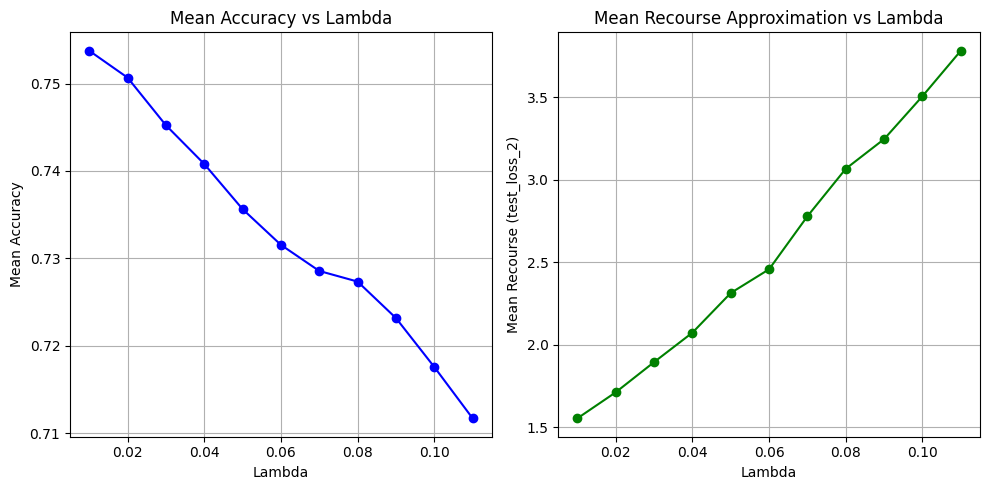

In [47]:
plt.figure(figsize=(10, 5))
lambdas = np.linspace(0.01, 0.11, 11)
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lambdas, mean_accuracies, marker='o', color='blue')
plt.title("Mean Accuracy vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Accuracy")
plt.grid(True)

# Recourse loss plot
plt.subplot(1, 2, 2)
plt.plot(lambdas, mean_recourse_approximations, marker='o', color='green')
plt.title("Mean Recourse Approximation vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse (test_loss_2)")
plt.grid(True)

plt.tight_layout()
plt.show()


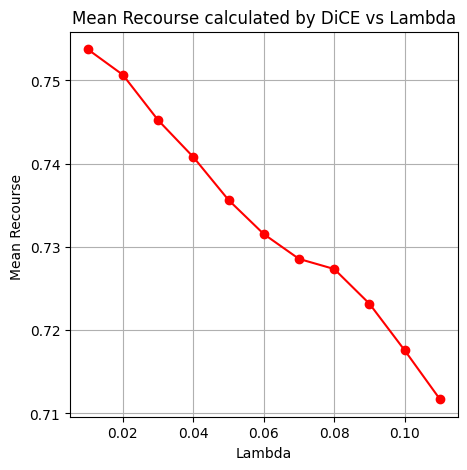

In [46]:
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))

plt.plot(lambdas, mean_accuracies, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

i think for lambda = 0.1 the results are ideal . for this lambda the mean recourse loss is 4.0515. here the recouse has doubled around 2.7 times which is a high improvement. But the accuracy took a hard hit sitting around which is not ideal Mean Accuracy: 0.7007

Why cant we use the actual recourse in the training .
Because the recourse given by dice is not differentiable.

In [ ]:
loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))